# Distribution of genome locatins for singleton clusters

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import re

## Calculate gene position in the genome

In [38]:
file_metadata = "~/2_protein_structure_prediction/virosphere-fold-v1_predicted_dataset.csv"
df_metadata = pd.read_csv(file_metadata)
file_genomes = "./genome_segment_lengths.csv"
df_genomes = pd.read_csv(file_genomes)
file_stats = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(file_stats)
file_meta = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv"
df_meta = pd.read_csv(file_meta)

In [3]:
df_metadata_sub = df_metadata[
    ['record_id',
     'protlen',
     'Sort',
     'nt_acc',
     'genbank_genome_coordinates']]

In [39]:
# merge df_meta with df_stats[['cluster_representative', 'cluster_size']] on 'cluster_representative'
df_meta_sub = pd.merge(df_meta, df_stats[['cluster_representative', 'cluster_size']], on='cluster_representative')

In [5]:
df_meta_sub = df_meta_sub[
    ['cluster_id',
     'cluster_size',
     'cluster_representative',
     'cluster_member',
     'clustering_method',
     'member_class',
     'member_record_id',
     'protlen']]

In [6]:
'''
Get nucleotide coordinates of the gene centre
using its Genbank genome coordinates
'''

def get_gene_centre(gene_coordinates):
    if 'join' in gene_coordinates:
        if '(+)' in gene_coordinates:
            gene_coordinates_start = gene_coordinates.lstrip('join{').rstrip('}').split(', ')[0]
            gene_coordinates_end = gene_coordinates.lstrip('join{').rstrip('}').split(', ')[-1]
        elif '(-)' in gene_coordinates:
            gene_coordinates_start = gene_coordinates.lstrip('join{').rstrip('}').split(', ')[-1]
            gene_coordinates_end = gene_coordinates.lstrip('join{').rstrip('}').split(', ')[0]
        gene_start = re.sub(r'[^0-9:]', '', gene_coordinates_start).split(':')[0]
        gene_end = re.sub(r'[^0-9:]', '', gene_coordinates_end).split(':')[-1]
        gene_centre = np.mean([int(gene_start), int(gene_end)])
    else:
        gene_coordinates = re.sub(r'[^0-9:]', '', gene_coordinates).split(':')
        gene_coordinates = [int(x) for x in gene_coordinates]
        gene_centre = np.mean(gene_coordinates)
    return gene_centre

In [ ]:
for index, row in df_metadata_sub.iterrows():
    nt_coord_str = row['genbank_genome_coordinates']
    gene_centre = get_gene_centre(nt_coord_str)
    df_metadata_sub.at[index, 'gene_centre'] = gene_centre
    nt_acc = row['nt_acc']
    genome_len = df_genomes.loc[df_genomes['nt_acc'] == nt_acc, 'genome_segment_length_bp'].values[0]
    normalised_gene_centre = round(gene_centre / genome_len,4)
    df_metadata_sub.at[index, 'normalised_gene_centre'] = normalised_gene_centre
    print(index, gene_centre, normalised_gene_centre)

In [8]:
df_metadata_sub.iloc[:,:]

,record_id,protlen,Sort,nt_acc,genbank_genome_coordinates,gene_centre,normalised_gene_centre
0,CAX33877.1.4_11504,11,11504,FM995220.1,[1606:1638](+),1622.0,0.4865
1,AAT67220.1.6_10459,12,10459,AY563023.1,[4311:4346](+),4328.5,0.5222
2,AAA73159.1_10363,12,10363,M80888.1,[931:>966](+),948.5,0.9819
3,CAD30689.1.5_11499,12,11499,AJ459382.1,[1588:1623](+),1605.5,0.4682
4,AGZ63355.1.1.1_10906,12,10906,KF387721.1,[595:630](+),612.5,0.0785
...,...,...,...,...,...,...,...
85157,ALZ45814.1_12442,4182,12442,KU216744.2,[252962:265510](-),259236.0,0.8639
85158,ALN66244.1_12439,4183,12439,KT995470.1,[195596:208147](-),201871.5,0.6860
85159,ASA40472.1_12441,4184,12441,KY827813.1,[189294:201848](-),195571.0,0.6958
85160,ATU83352.1_12444,4184,12444,MF768985.1,[239180:251734](-),245457.0,0.8583


In [9]:
# merge df_metadata_sub with df_meta_sub on 'record_id' ('member_record_id' in df_meta_sub)
df_metadata_sub = pd.merge(df_metadata_sub, df_meta_sub[['member_record_id', 'cluster_size']], left_on='record_id', right_on='member_record_id')
df_metadata_sub = df_metadata_sub.drop(columns=['member_record_id'])

In [44]:
df_metadata_sub

,record_id,protlen,Sort,nt_acc,genbank_genome_coordinates,gene_centre,normalised_gene_centre,cluster_size,network_1E-3,network_1E-4,network_1E-5
0,CAX33877.1.4_11504,11,11504,FM995220.1,[1606:1638](+),1622.0,0.4865,1,0,0,0
1,AAT67220.1.6_10459,12,10459,AY563023.1,[4311:4346](+),4328.5,0.5222,1,0,0,0
2,AAA73159.1_10363,12,10363,M80888.1,[931:>966](+),948.5,0.9819,1,0,0,0
3,CAD30689.1.5_11499,12,11499,AJ459382.1,[1588:1623](+),1605.5,0.4682,1,0,0,0
4,AGZ63355.1.1.1_10906,12,10906,KF387721.1,[595:630](+),612.5,0.0785,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
85157,ALZ45814.1_12442,4182,12442,KU216744.2,[252962:265510](-),259236.0,0.8639,10,1,1,1
85158,ALN66244.1_12439,4183,12439,KT995470.1,[195596:208147](-),201871.5,0.6860,10,1,1,1
85159,ASA40472.1_12441,4184,12441,KY827813.1,[189294:201848](-),195571.0,0.6958,10,1,1,1
85160,ATU83352.1_12444,4184,12444,MF768985.1,[239180:251734](-),245457.0,0.8583,10,1,1,1


In [45]:
df_metadata_sub.to_csv('metadata_normalised_gene_centre_position.csv', index=False)

## Visualize gene position

In [25]:
gene_position_file = "./metadata_normalised_gene_centre_position.csv"
df_gene_position = pd.read_csv(gene_position_file)
meta_file = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv"
df_meta = pd.read_csv(meta_file)
stats_file = "~/7_functional_coverage_expansion/foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(stats_file)
ictv_file = "~/1_dataset_preparation/msl38v2/VMR_MSL38_v2.xlsx"
df_ictv = pd.read_excel(ictv_file)

In [26]:
df_meta = df_meta.merge(df_stats[['cluster_id', 'cluster_size']], on='cluster_id')

In [27]:
df_gene_position.drop(columns=[
    'cluster_size',
    'network_1E-3',
    'network_1E-4',
    'network_1E-5'], inplace=True)

In [28]:
df_gene_position = df_gene_position.merge(df_ictv[['Sort', 'Realm']], on='Sort')

In [29]:
df_gene_position['Realm'].fillna('Unclassified', inplace=True)

In [30]:
df_gene_position = df_gene_position.merge(df_meta[['member_record_id', 'cluster_size']], left_on='record_id', right_on='member_record_id')
df_gene_position.drop(columns=['member_record_id'], inplace=True)

In [31]:
df_gene_position['singleton'] = df_gene_position['cluster_size'].apply(lambda x: 'singleton' if x == 1 else 'non-singleton')

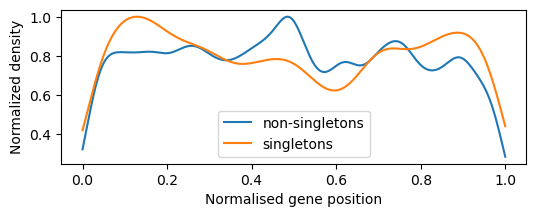

In [41]:
# Split the data based on 'Pfam_annotation_type'
data1 = df_gene_position[df_gene_position['cluster_size'] >= 1]['normalised_gene_centre']
data2 = df_gene_position[df_gene_position['cluster_size'] == 1]['normalised_gene_centre']

# Compute KDE
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# Create a range of values for the x-axis
x = np.linspace(0, 1, 1000)

# Compute the densities
density1 = kde1(x)
density2 = kde2(x)

# Normalize the densities
density1 /= density1.max()
density2 /= density2.max()

# Plot the normalized densities
plt.figure(figsize=(6, 2))
plt.plot(x, density1, label='non-singletons')
plt.plot(x, density2, label='singletons')
plt.xlabel('Normalised gene position')
plt.ylabel('Normalized density')
plt.legend()
plt.savefig('./figures/singleton_genome_location/kde_singleton_gene_position.svg', bbox_inches='tight', format='svg')
plt.show()

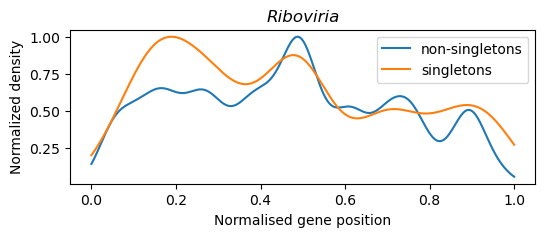

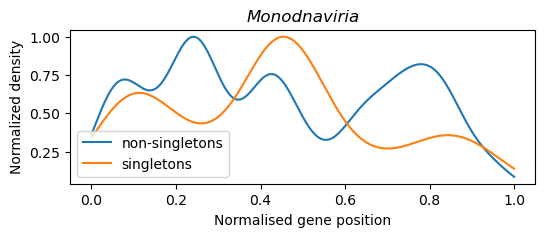

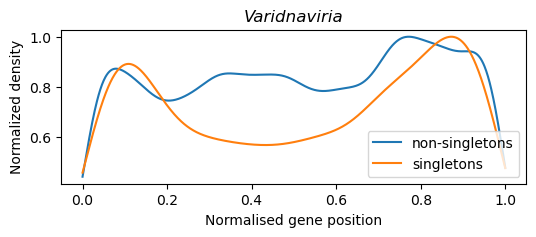

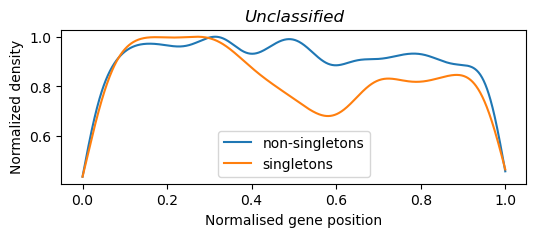

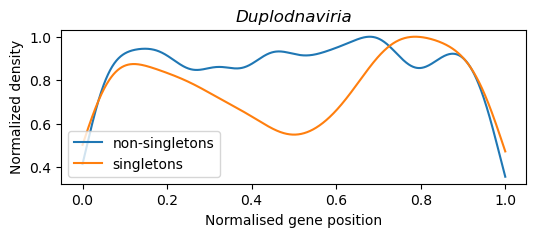

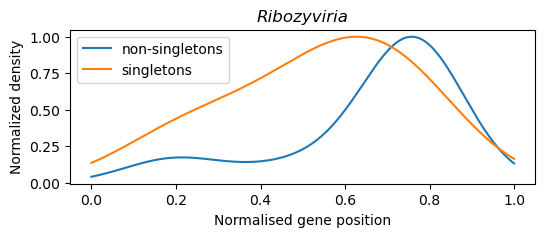

In [ ]:
for realm in df_gene_position['Realm'].unique():
    
    # Split the data based on 'Pfam_annotation_type'
    data1 = df_gene_position[(df_gene_position['cluster_size'] >= 1) & (df_gene_position['Realm'] == realm)]['normalised_gene_centre']
    data2 = df_gene_position[(df_gene_position['cluster_size'] == 1) & (df_gene_position['Realm'] == realm)]['normalised_gene_centre']

    # Compute KDE
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    # Create a range of values for the x-axis
    x = np.linspace(0, 1, 1000)

    # Compute the densities
    density1 = kde1(x)
    density2 = kde2(x)

    # Normalize the densities
    density1 /= density1.max()
    density2 /= density2.max()

    # Plot the normalized densities
    plt.figure(figsize=(6, 2))
    plt.plot(x, density1, label='non-singletons')
    plt.plot(x, density2, label='singletons')
    plt.xlabel('Normalised gene position')
    plt.ylabel('Normalized density')
    # make title italic
    plt.title(f'{realm}', fontstyle='italic')
    plt.legend()
    plt.savefig(f'./figures/singleton_genome_location/kde_singleton_gene_position_{realm}.svg', bbox_inches='tight', format='svg')
    plt.show()